[INFO] Using device: cuda
Loading dataset paths...
Scanning K:\Code\Project\Research Paper\Emotion Detection\facial_data\archive ...
Found 35887 images across 7 emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of labels (classes): 7
Starting training...


Epoch [1/30] Train: 52.95% | Val: 63.79%
✅ Best model saved (Val Acc: 63.79%)


Epoch [2/30] Train: 68.35% | Val: 66.50%
✅ Best model saved (Val Acc: 66.50%)


Epoch [3/30] Train: 77.53% | Val: 67.34%
✅ Best model saved (Val Acc: 67.34%)


Epoch [4/30] Train: 85.06% | Val: 66.86%


Epoch [5/30] Train: 90.15% | Val: 68.01%
✅ Best model saved (Val Acc: 68.01%)


Epoch [6/30] Train: 93.28% | Val: 67.41%


Epoch [7/30] Train: 94.23% | Val: 68.03%
✅ Best model saved (Val Acc: 68.03%)


Epoch [8/30] Train: 95.24% | Val: 67.70%


Epoch [9/30] Train: 95.93% | Val: 67.53%


Epoch [10/30] Train: 96.15% | Val: 67.85%


Epoch [11/30] Train: 96.65% | Val: 68.56%
✅ Best model saved (Val Acc: 68.56%)


Epoch [12/30] Train: 96.75% | Val: 68.80%
✅ Best model saved (Val Acc: 68.80%)


Epoch [13/30] Train: 97.09% | Val: 68.31%


Epoch [14/30] Train: 97.13% | Val: 66.52%


Epoch [15/30] Train: 97.34% | Val: 67.66%


Epoch [16/30] Train: 97.29% | Val: 67.59%


Epoch [17/30] Train: 97.42% | Val: 68.05%


Epoch [18/30] Train: 97.75% | Val: 68.29%


Epoch [19/30] Train: 97.79% | Val: 67.81%


Epoch [20/30] Train: 97.92% | Val: 67.34%


Epoch [21/30] Train: 98.01% | Val: 68.06%


Epoch [22/30] Train: 97.68% | Val: 68.11%


Epoch [23/30] Train: 98.06% | Val: 68.07%


Epoch [24/30] Train: 98.03% | Val: 68.16%


Epoch [25/30] Train: 98.22% | Val: 68.29%


Epoch [26/30] Train: 98.20% | Val: 67.39%


Epoch [27/30] Train: 98.14% | Val: 67.77%


Epoch [28/30] Train: 98.26% | Val: 68.38%


Epoch [29/30] Train: 98.42% | Val: 67.50%


Epoch [30/30] Train: 98.20% | Val: 67.45%


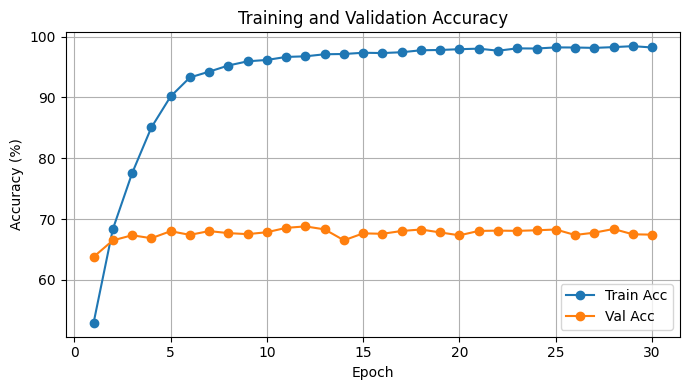

Loaded best model with Val Acc: 68.80%


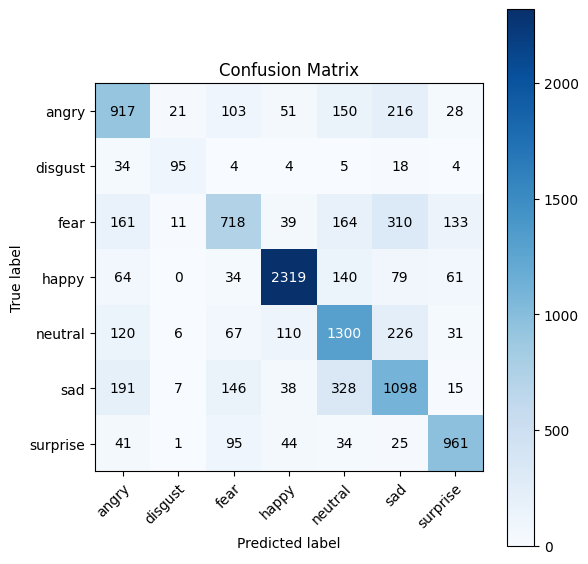

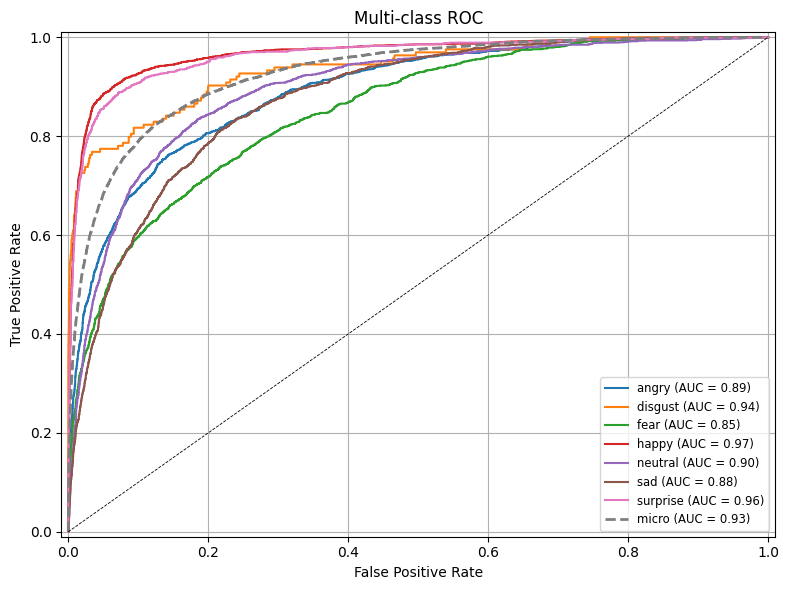


Per-Class Metrics:
       angry: Precision=0.600, Recall=0.617, F1=0.608
     disgust: Precision=0.674, Recall=0.579, F1=0.623
        fear: Precision=0.615, Recall=0.467, F1=0.531
       happy: Precision=0.890, Recall=0.860, F1=0.875
     neutral: Precision=0.613, Recall=0.699, F1=0.653
         sad: Precision=0.557, Recall=0.602, F1=0.579
    surprise: Precision=0.779, Recall=0.800, F1=0.790

Overall Averages:
  Macro Precision: 0.675
  Macro Recall:    0.661
  Macro F1:        0.666
Final model saved to K:\Code\Project\Research Paper\Emotion Detection\efficientnetv3_face_emotion_final.pth


In [1]:
import os
import random
import copy
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score  # ✅ Added
from sklearn.preprocessing import label_binarize

# ==========================================================
# CONFIG
# ==========================================================
ROOT_DATA_DIRS = [
    r"K:\Code\Project\Research Paper\Emotion Detection\facial_data\archive"
]

DEFAULT_MODEL_PATH = r"K:\Code\Project\Research Paper\Emotion Detection\efficientnetv3_face_emotion.pth"
EMOTIONS_NPY = r"K:\Code\Project\Research Paper\Emotion Detection\emotions_face.npy"
TEST_IMAGE = r"K:\Code\Project\Research Paper\Emotion Detection\test5.jpg"

SEED = 42
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 30
IMG_SIZE = 256  # InceptionV3 requires 299x299
NUM_WORKERS = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# ==========================================================
# SEED
# ==========================================================
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

# ==========================================================
# DATASET
# ==========================================================
class FaceEmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)
        return img_t, label


# ==========================================================
# MODEL (EfficientNetV2)
# ==========================================================
class EfficientNetV2_Emotion(nn.Module):
    def __init__(self, num_classes=8, pretrained=True, version="s"):
        super().__init__()

        # Choose model size
        if version == "s":
            weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None
            self.base = models.efficientnet_v2_s(weights=weights)
        elif version == "m":
            weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1 if pretrained else None
            self.base = models.efficientnet_v2_m(weights=weights)
        elif version == "l":
            weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1 if pretrained else None
            self.base = models.efficientnet_v2_l(weights=weights)
        else:
            raise ValueError("version must be: 's', 'm', or 'l'")

        # Replace classification head
        in_features = self.base.classifier[1].in_features
        self.base.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base(x)


# ==========================================================
# DATA UTILITIES
# ==========================================================
def load_multiple_datasets(dir_list):
    image_paths, labels = [], []
    emotions = set()
    for root_dir in dir_list:
        print(f"Scanning {root_dir} ...")
        for subdir, _, files in os.walk(root_dir):
            if not files:
                continue
            img_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if not img_files:
                continue
            emotion = os.path.basename(subdir).lower()
            emotions.add(emotion)
            for fname in img_files:
                image_paths.append(os.path.join(subdir, fname))
                labels.append(emotion)
    emotions = sorted(list(emotions))
    emotion_to_idx = {emo: i for i, emo in enumerate(emotions)}
    numeric_labels = [emotion_to_idx[l] for l in labels]
    print(f"Found {len(image_paths)} images across {len(emotions)} emotions: {emotions}")
    return image_paths, numeric_labels, emotions

# ==========================================================
# PLOT HELPERS
# ==========================================================
def plot_accuracy(train_accs, val_accs):
    epochs = np.arange(1, len(train_accs) + 1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, val_accs, marker='o', label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(y_true, y_score, n_classes, labels):
    plt.figure(figsize=(8,6))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro (AUC = {roc_auc["micro"]:.2f})', linestyle='--', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=0.6)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==========================================================
# TRAINING LOOP
# ==========================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    model.to(device)
    best_val_acc = -1.0
    best_state = None
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_correct, running_total = 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
            train_acc = 100.0 * running_correct / running_total
            pbar.set_postfix({"TrainAcc": f"{train_acc:.2f}%"})

        epoch_train_acc = train_acc
        train_acc_history.append(epoch_train_acc)

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        all_targets, all_probs = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                probs = F.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
                all_targets.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())

        epoch_val_acc = 100.0 * val_correct / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Train: {epoch_train_acc:.2f}% | Val: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_state = {'model_state': copy.deepcopy(model.state_dict())}
            torch.save(best_state['model_state'], DEFAULT_MODEL_PATH)
            print(f"✅ Best model saved (Val Acc: {best_val_acc:.2f}%)")

    return {'train_acc': train_acc_history, 'val_acc': val_acc_history, 'best_val_acc': best_val_acc, 'best_state': best_state}

# ==========================================================
# EVALUATION & PREDICTION (✅ Extended with Precision, Recall, F1)
# ==========================================================
def evaluate_and_plot(model, loader, emotions):
    model.eval()
    all_true, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_true.append(labels.numpy())

    y_score = np.vstack(all_probs)
    y_true = np.concatenate(all_true)
    n_classes = len(emotions)
    y_pred = np.argmax(y_score, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
    plot_confusion_matrix(cm, emotions)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    plot_multiclass_roc(y_true_bin, y_score, n_classes, emotions)

    # ✅ Added: Precision, Recall, F1-score
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print("\nPer-Class Metrics:")
    for i, label in enumerate(emotions):
        print(f"{label:>12s}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")
    print("\nOverall Averages:")
    print(f"  Macro Precision: {precision.mean():.3f}")
    print(f"  Macro Recall:    {recall.mean():.3f}")
    print(f"  Macro F1:        {f1.mean():.3f}")

def predict_single(model, img_path, transform, emotions):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1)
        idx = int(probs.argmax(dim=1).cpu().numpy()[0])
    return emotions[idx], float(probs.max().cpu().numpy())

# ==========================================================
# MAIN
# ==========================================================
def main():
    choice = input("Do you want to load the saved model? (yes/no): ").strip().lower()
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]
    preprocess = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    print("Loading dataset paths...")
    image_paths, numeric_labels, emotions = load_multiple_datasets(ROOT_DATA_DIRS)
    n_classes = len(emotions)
    print(f"Number of labels (classes): {n_classes}")

    np.save(EMOTIONS_NPY, emotions)

    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, numeric_labels, test_size=0.3, random_state=SEED, stratify=numeric_labels
    )

    train_ds = FaceEmotionDataset(X_train, y_train, transform=preprocess)
    val_ds   = FaceEmotionDataset(X_val, y_val, transform=preprocess)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = EfficientNetV2_Emotion(num_classes=n_classes, version="s")

    if os.path.exists(DEFAULT_MODEL_PATH) and choice == "yes":
        print("Loading model from", DEFAULT_MODEL_PATH)
        model.load_state_dict(torch.load(DEFAULT_MODEL_PATH, map_location=device))
        model.to(device)
        evaluate_and_plot(model, val_loader, emotions)
        if os.path.exists(TEST_IMAGE):
            pred, conf = predict_single(model, TEST_IMAGE, preprocess, emotions)
            print(f"Predicted Emotion: {pred} (confidence {conf:.3f})")
        return

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    print("Starting training...")
    stats = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)
    plot_accuracy(stats['train_acc'], stats['val_acc'])

    if stats['best_state'] is not None:
        model.load_state_dict(stats['best_state']['model_state'])
        print(f"Loaded best model with Val Acc: {stats['best_val_acc']:.2f}%")

    evaluate_and_plot(model, val_loader, emotions)
    final_save = os.path.splitext(DEFAULT_MODEL_PATH)[0] + "_final.pth"
    torch.save(model.state_dict(), final_save)
    print(f"Final model saved to {final_save}")

if __name__ == "__main__":
    main()
